In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
# For handling Excel files
import openpyxl
# For progress bars
from tqdm.notebook import tqdm
# Setting plot style
sns.set(style="whitegrid")
%matplotlib inline
import glob
import shutil
import random
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [2]:
import os
import shutil
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define the path to the original dataset directory
original_dataset_dir = '/kaggle/input/moderate-imbalance-leukemia/Moderate imbalance'

# Define paths for the train and test sets
train_dir = {
    'all': os.path.join(original_dataset_dir, 'Train', 'all'),
    'hem': os.path.join(original_dataset_dir, 'Train', 'hem')
}
test_dir = {
    'all': os.path.join(original_dataset_dir, 'Test', 'all'),
    'hem': os.path.join(original_dataset_dir, 'Test', 'hem')
}

# Define the working directory to copy the dataset
working_dir = '/kaggle/working/imbalance-leukemia/High_imbalance'

# Create the target directories in the working directory if they don't exist
os.makedirs(os.path.join(working_dir, 'Train', 'all'), exist_ok=True)
os.makedirs(os.path.join(working_dir, 'Train', 'hem'), exist_ok=True)
os.makedirs(os.path.join(working_dir, 'Test', 'all'), exist_ok=True)
os.makedirs(os.path.join(working_dir, 'Test', 'hem'), exist_ok=True)

# Copy data from the original dataset to the working directory
try:
    shutil.copytree(train_dir['all'], os.path.join(working_dir, 'Train', 'all'), dirs_exist_ok=True)
    shutil.copytree(train_dir['hem'], os.path.join(working_dir, 'Train', 'hem'), dirs_exist_ok=True)
    shutil.copytree(test_dir['all'], os.path.join(working_dir, 'Test', 'all'), dirs_exist_ok=True)
    shutil.copytree(test_dir['hem'], os.path.join(working_dir, 'Test', 'hem'), dirs_exist_ok=True)
    print("Files copied successfully!")
except Exception as e:
    print(f"Error during copying: {e}")

# Define the LeukemiaDataset class
class LeukemiaDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        
        # Iterate over all subdirectories (all, hem) and get the images
        for label, sub_dir in enumerate(['all', 'hem']):
            class_dir = os.path.join(data_dir, sub_dir)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_files.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.labels[idx]
        
        # Load image and convert to RGB
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the paths for the new train and test sets in the working directory
train_dir_working = {
    'all': os.path.join(working_dir, 'Train', 'all'),
    'hem': os.path.join(working_dir, 'Train', 'hem')
}
test_dir_working = {
    'all': os.path.join(working_dir, 'Test', 'all'),
    'hem': os.path.join(working_dir, 'Test', 'hem')
}

# Load train and test datasets from the working directory
train_dataset = LeukemiaDataset(data_dir=os.path.join(working_dir, 'Train'), transform=train_transform)
test_dataset = LeukemiaDataset(data_dir=os.path.join(working_dir, 'Test'), transform=val_test_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to count the number of files in each directory
def count_files_in_dir(directory):
    file_count = 0
    for sub_dir in ['all', 'hem']:  # Check both 'all' and 'hem' directories
        class_dir = os.path.join(directory, sub_dir)
        if os.path.exists(class_dir):
            file_count += len(os.listdir(class_dir))  # Count files in the sub-directory
    return file_count

# Count files in the training and testing datasets
train_file_count = count_files_in_dir(os.path.join(working_dir, 'Train'))
test_file_count = count_files_in_dir(os.path.join(working_dir, 'Test'))

# Print the counts
print(f"Training set - Total files: {train_file_count}")
print(f"Testing set - Total files: {test_file_count}")


Files copied successfully!
Training set - Total files: 110
Testing set - Total files: 60


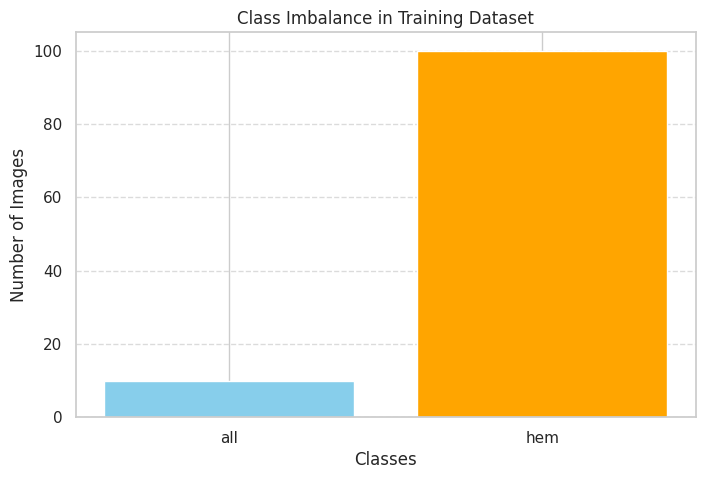

In [3]:
import matplotlib.pyplot as plt

# Function to count the number of images per class
def count_class_distribution(directory):
    class_counts = {}
    for class_name in ['all', 'hem']:
        class_dir = os.path.join(directory, class_name)
        if os.path.exists(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
        else:
            class_counts[class_name] = 0
    return class_counts

# Count class distribution for training set
train_class_counts = count_class_distribution(os.path.join(working_dir, 'Train'))

# Plotting the class distributions for training set
def plot_train_class_distribution(train_counts):
    labels = list(train_counts.keys())
    train_values = list(train_counts.values())

    plt.figure(figsize=(8, 5))
    plt.bar(labels, train_values, color=['skyblue', 'orange'])
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Imbalance in Training Dataset')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot the graph
plot_train_class_distribution(train_class_counts)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import timm

In [5]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, channels, _, _ = x.size()
        se = self.global_avg_pool(x).view(batch_size, channels)
        se = self.fc1(se)
        se = self.relu(se)
        se = self.fc2(se)
        se = self.sigmoid(se).view(batch_size, channels, 1, 1)
        return x * se

class GhostNetWithFinalSE(nn.Module):
    def __init__(self, num_classes=10):
        super(GhostNetWithFinalSE, self).__init__()
        # Initialize GhostNet without pre-trained weights
        self.base_model = timm.create_model('ghostnet_100', pretrained=False, num_classes=num_classes)
        self.features = self.base_model.forward_features  # Feature extraction part
        
        # 960 is the number of channels output by GhostNet
        self.se_block = SEBlock(960, reduction=16)  # Add SE block (960 is the default output channels of GhostNet)
        
        self.pool = nn.AdaptiveAvgPool2d(1)  # Global average pooling
        self.fc = nn.Linear(960, num_classes)  # Final classifier (960 channels)

    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = self.se_block(x)  # Apply SE block
        x = self.pool(x)  # Global average pooling
        x = torch.flatten(x, 1)  # Flatten for classification
        x = self.fc(x)  # Final classification
        return x


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 2

model = GhostNetWithFinalSE(num_classes=num_classes) 

model.to(device)


GhostNetWithFinalSE(
  (base_model): GhostNet(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): GhostBottleneck(
          (ghost1): GhostModule(
            (primary_conv): Sequential(
              (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (cheap_operation): Sequential(
              (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (ghost2): GhostModule(
            

In [7]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
print(model)

GhostNetWithFinalSE(
  (base_model): GhostNet(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): GhostBottleneck(
          (ghost1): GhostModule(
            (primary_conv): Sequential(
              (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (cheap_operation): Sequential(
              (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (ghost2): GhostModule(
            

In [8]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=50):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dataloader, desc=phase.capitalize()):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()
    
    print(f'Best Validation Acc: {best_acc:.4f}')
    
    model.load_state_dict(best_model_wts)
    return model, history


In [13]:
from tqdm import tqdm  # Import tqdm for progress bars

# Train the model
num_epochs = 50
model, history = train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs=num_epochs)


Epoch 1/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


Train Loss: 0.0869 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]


Val Loss: 0.6215 Acc: 0.7500

Epoch 2/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


Train Loss: 0.0834 Acc: 0.9818


Val: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


Val Loss: 0.6417 Acc: 0.7167

Epoch 3/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


Train Loss: 0.0760 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00,  9.74it/s]


Val Loss: 0.6471 Acc: 0.7167

Epoch 4/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


Train Loss: 0.1234 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


Val Loss: 0.6743 Acc: 0.7167

Epoch 5/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


Train Loss: 0.0979 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


Val Loss: 0.6411 Acc: 0.7333

Epoch 6/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


Train Loss: 0.0874 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]


Val Loss: 0.6279 Acc: 0.7333

Epoch 7/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Train Loss: 0.1129 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]

Val Loss: 0.6068 Acc: 0.7500

Epoch 8/50
----------



Train: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Train Loss: 0.0966 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


Val Loss: 0.6106 Acc: 0.7500

Epoch 9/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Train Loss: 0.0790 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]

Val Loss: 0.6083 Acc: 0.7500

Epoch 10/50
----------



Train: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Train Loss: 0.0592 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]


Val Loss: 0.6169 Acc: 0.7500

Epoch 11/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


Train Loss: 0.1197 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  8.06it/s]


Val Loss: 0.6212 Acc: 0.7500

Epoch 12/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


Train Loss: 0.0866 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]


Val Loss: 0.6251 Acc: 0.7500

Epoch 13/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Train Loss: 0.1177 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


Val Loss: 0.6530 Acc: 0.7500

Epoch 14/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Train Loss: 0.1465 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


Val Loss: 0.6398 Acc: 0.7333

Epoch 15/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


Train Loss: 0.1386 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


Val Loss: 0.6303 Acc: 0.7500

Epoch 16/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


Train Loss: 0.1000 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


Val Loss: 0.6155 Acc: 0.7500

Epoch 17/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


Train Loss: 0.0764 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]


Val Loss: 0.6140 Acc: 0.7500

Epoch 18/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Train Loss: 0.0964 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  8.51it/s]


Val Loss: 0.5865 Acc: 0.7500

Epoch 19/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


Train Loss: 0.1323 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


Val Loss: 0.6158 Acc: 0.7500

Epoch 20/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Train Loss: 0.0666 Acc: 0.9818


Val: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


Val Loss: 0.6319 Acc: 0.7500

Epoch 21/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Train Loss: 0.0872 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


Val Loss: 0.6534 Acc: 0.7500

Epoch 22/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Train Loss: 0.1364 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


Val Loss: 0.5931 Acc: 0.7667

Epoch 23/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.0739 Acc: 0.9818


Val: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


Val Loss: 0.6027 Acc: 0.7667

Epoch 24/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


Train Loss: 0.1218 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]


Val Loss: 0.6072 Acc: 0.7500

Epoch 25/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Train Loss: 0.1139 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


Val Loss: 0.5832 Acc: 0.7500

Epoch 26/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


Train Loss: 0.1108 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


Val Loss: 0.5690 Acc: 0.7500

Epoch 27/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Train Loss: 0.0744 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


Val Loss: 0.5606 Acc: 0.7500

Epoch 28/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Train Loss: 0.1070 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


Val Loss: 0.5873 Acc: 0.7500

Epoch 29/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Train Loss: 0.0611 Acc: 0.9818


Val: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


Val Loss: 0.5987 Acc: 0.7500

Epoch 30/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


Train Loss: 0.0894 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]

Val Loss: 0.6115 Acc: 0.7500



Epoch 31/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Train Loss: 0.1064 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


Val Loss: 0.6230 Acc: 0.7667

Epoch 32/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Train Loss: 0.1063 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]


Val Loss: 0.6374 Acc: 0.7500

Epoch 33/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


Train Loss: 0.0921 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


Val Loss: 0.5921 Acc: 0.7500

Epoch 34/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


Train Loss: 0.0895 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]


Val Loss: 0.5791 Acc: 0.7500

Epoch 35/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Train Loss: 0.0790 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


Val Loss: 0.5584 Acc: 0.7500

Epoch 36/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Train Loss: 0.0648 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]

Val Loss: 0.5571 Acc: 0.7500

Epoch 37/50
----------



Train: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Train Loss: 0.0900 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]


Val Loss: 0.5813 Acc: 0.7500

Epoch 38/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.0830 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


Val Loss: 0.6070 Acc: 0.7500

Epoch 39/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Train Loss: 0.1000 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]


Val Loss: 0.6018 Acc: 0.7500

Epoch 40/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


Train Loss: 0.0993 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]


Val Loss: 0.6136 Acc: 0.7500

Epoch 41/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Train Loss: 0.0635 Acc: 0.9818


Val: 100%|██████████| 2/2 [00:00<00:00, 10.03it/s]


Val Loss: 0.6422 Acc: 0.7333

Epoch 42/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Train Loss: 0.1154 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


Val Loss: 0.6448 Acc: 0.7333

Epoch 43/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


Train Loss: 0.0983 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


Val Loss: 0.6171 Acc: 0.7500

Epoch 44/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


Train Loss: 0.0872 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


Val Loss: 0.6060 Acc: 0.7500

Epoch 45/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Train Loss: 0.0603 Acc: 0.9818


Val: 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


Val Loss: 0.6125 Acc: 0.7500

Epoch 46/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Train Loss: 0.0969 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


Val Loss: 0.6237 Acc: 0.7500

Epoch 47/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


Train Loss: 0.0612 Acc: 0.9818


Val: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


Val Loss: 0.6259 Acc: 0.7333

Epoch 48/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


Train Loss: 0.0682 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


Val Loss: 0.6314 Acc: 0.7333

Epoch 49/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Train Loss: 0.0976 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


Val Loss: 0.6462 Acc: 0.7333

Epoch 50/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Train Loss: 0.0889 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


Val Loss: 0.6005 Acc: 0.7500

Best Validation Acc: 0.7667


Testing: 100%|██████████| 2/2 [00:00<00:00, 10.83it/s]


Classification Report:
              precision    recall  f1-score   support

         All       0.89      0.57      0.69        30
         Hem       0.68      0.93      0.79        30

    accuracy                           0.75        60
   macro avg       0.79      0.75      0.74        60
weighted avg       0.79      0.75      0.74        60



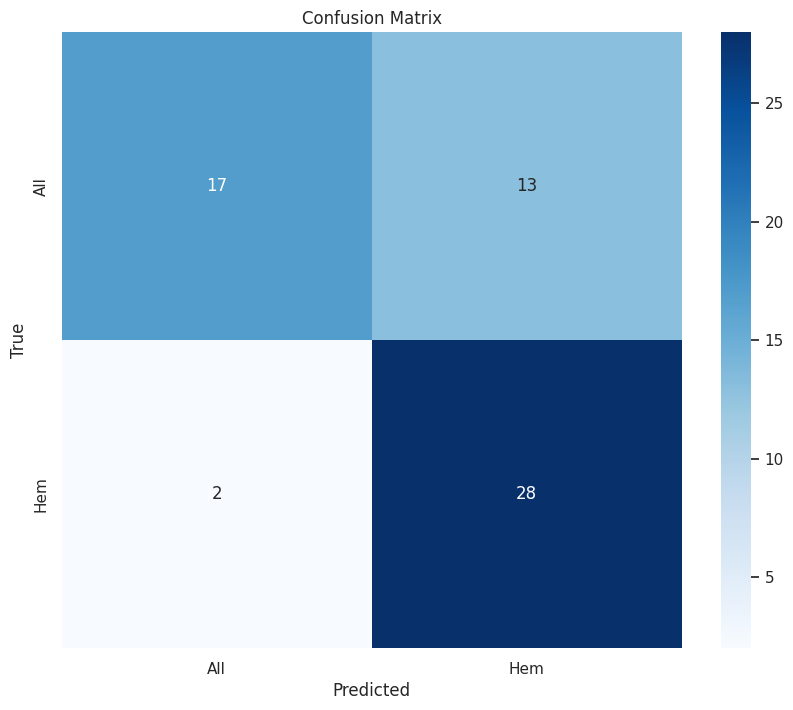

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model on the test set
evaluate_model(model, test_loader, classes=['All', 'Hem'])

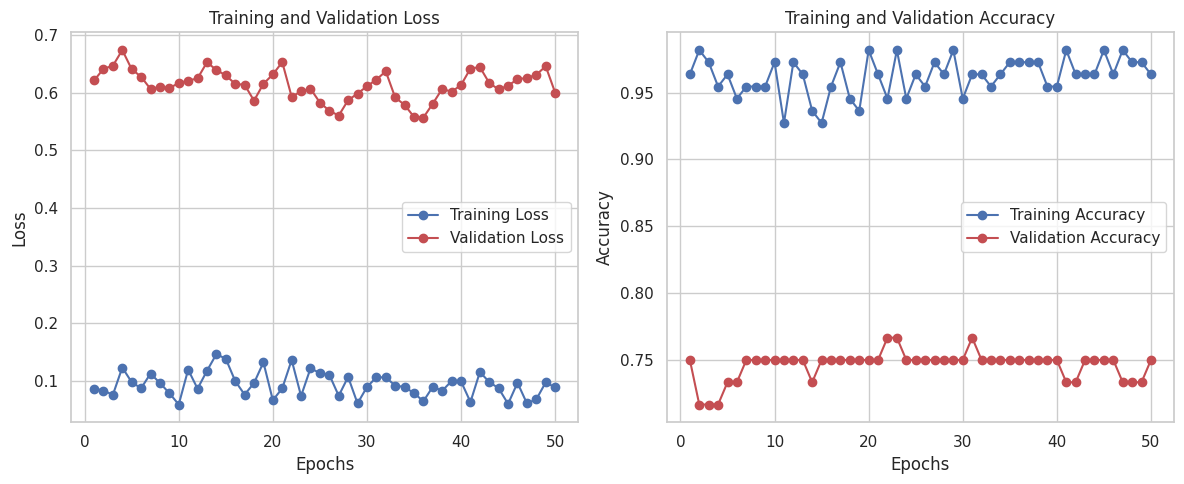

In [16]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)


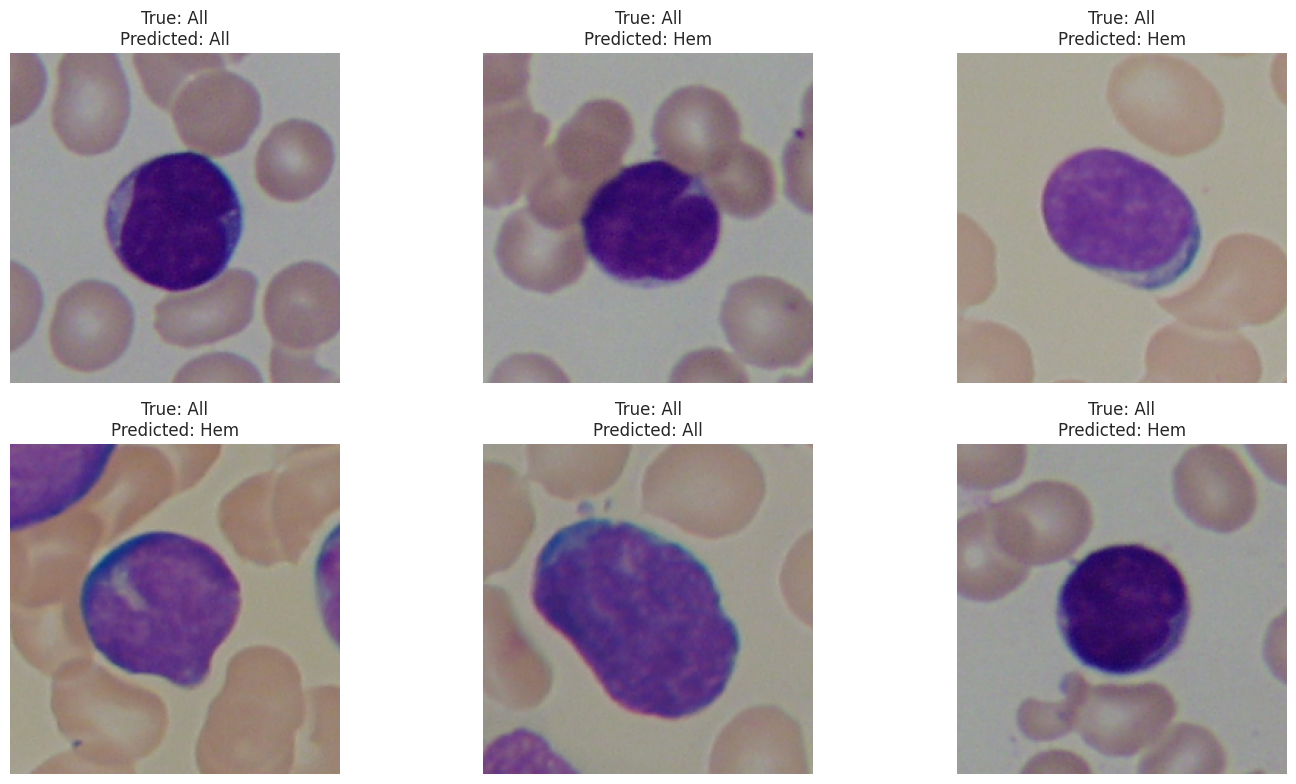

In [17]:
import numpy as np
def visualize_predictions(model, dataloader, classes, num_images=6):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        img = images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"True: {classes[labels[i]]}\nPredicted: {classes[preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample predictions
visualize_predictions(model, test_loader, classes=['All', 'Hem'], num_images=6)
